In [2]:
import os
import datetime

import IPython
import IPython.display
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import tensorflow as tf
from tensorflow.keras import optimizers

mpl.rcParams['figure.figsize'] = (8, 6)
mpl.rcParams['axes.grid'] = False

Adam = optimizers.Adam(lr=0.001)

In [3]:
csv_path_train = 'testset/J0003_0024_0221_20110307012732_cell_03.csv'
csv_path_test = 'testset/J0003_0024_0221_20110307012732_cell_03.csv'
df = pd.read_csv(csv_path_train)
df_test = pd.read_csv(csv_path_test)

date_time = pd.to_datetime(df.pop('MeasuredDate'), format='%Y.%m.%d %H:%M')
date_time_test = pd.to_datetime(df_test.pop('MeasuredDate'), format='%Y.%m.%d %H:%M')

In [4]:
df.head()

,CellNo,Resistance,Volt,Temp
0,3,0.298,2.23,-20
1,3,0.298,2.23,-20
2,3,0.297,2.24,-20
3,3,0.299,2.23,-20
4,3,0.298,2.24,-20


In [5]:
df_test.head()

,CellNo,Resistance,Volt,Temp
0,3,0.298,2.23,-20
1,3,0.298,2.23,-20
2,3,0.297,2.24,-20
3,3,0.299,2.23,-20
4,3,0.298,2.24,-20


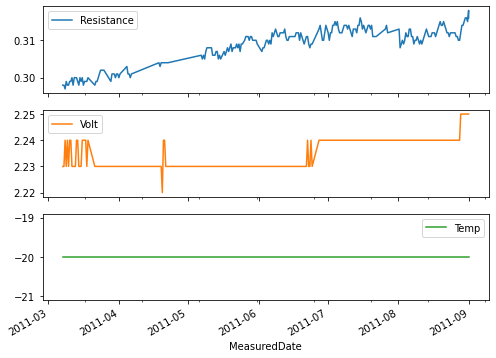

In [6]:
plot_cols = ['Resistance', 'Volt', 'Temp']
plot_features = df[plot_cols]
plot_features.index = date_time
_ = plot_features.plot(subplots=True)


array([<AxesSubplot:xlabel='MeasuredDate'>,
       <AxesSubplot:xlabel='MeasuredDate'>,
       <AxesSubplot:xlabel='MeasuredDate'>], dtype=object)

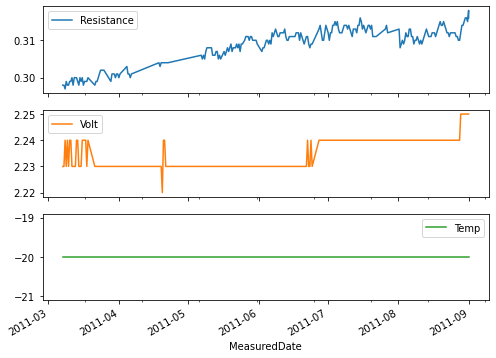

In [7]:
#plot_cols = ['Resistance', 'Volt', 'Temp']
plot_features_test = df_test[plot_cols]
plot_features_test.index = date_time_test
plot_features_test.plot(subplots=True)

In [8]:
df.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
CellNo,258.0,3.000000,0.000000,3.000,3.000,3.00,3.000,3.000
Resistance,258.0,0.308775,0.004947,0.297,0.306,0.31,0.312,0.318
Volt,258.0,2.235388,0.005721,2.220,2.230,2.24,2.240,2.250
Temp,258.0,-20.000000,0.000000,-20.000,-20.000,-20.00,-20.000,-20.000


In [9]:
column_indices = {name: i for i, name in enumerate(df.columns)}
column_indices = {name: i for i, name in enumerate(df_test.columns)}

In [10]:
from sklearn.preprocessing import MinMaxScaler, StandardScaler

scaler = MinMaxScaler()
df = scaler.fit_transform(df[plot_cols])
df_test = scaler.fit_transform(df_test[plot_cols])
df = pd.DataFrame(df)
df_test = pd.DataFrame(df_test)
df.columns = plot_cols
df_test.columns = plot_cols

In [11]:
n = len(df)
train_df = df[0:int(n*0.7)]
val_df = df[int(n*0.7):int(n*0.8)]
test_df = df[int(n*0.8):]
#n_test = len(df_test)
test_df_test = df_test[:int(n*0.7)]
label_df = df_test[int(n*0.7):]

num_features = df.shape[1]
#print(int(n*0.8),int(n*0.2),len(test_df), len(label_df))

In [12]:
df.head()

,Resistance,Volt,Temp
0,0.047619,0.333333,0.0
1,0.047619,0.333333,0.0
2,0.000000,0.666667,0.0
3,0.095238,0.333333,0.0
4,0.047619,0.666667,0.0


<AxesSubplot:>

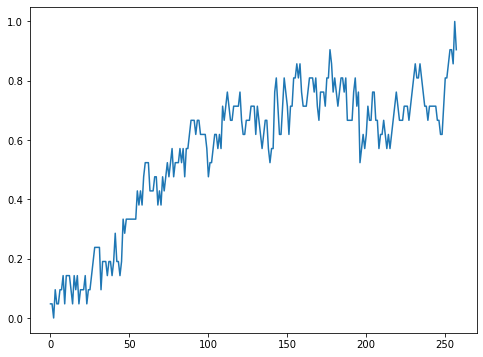

In [13]:
df['Resistance'].plot()

In [14]:
class WindowGenerator():
    def __init__(self, input_width, label_width, shift,
               train_df=train_df, val_df=val_df, test_df=test_df,
               label_columns=None):
        # Store the raw data.
        self.train_df = train_df
        self.val_df = val_df
        self.test_df = test_df

    # Work out the label column indices.
        self.label_columns = label_columns
        if label_columns is not None:
            self.label_columns_indices = {name: i for i, name in
                                    enumerate(label_columns)}
        self.column_indices = {name: i for i, name in
                           enumerate(train_df.columns)}

    # Work out the window parameters.
        self.input_width = input_width
        self.label_width = label_width
        self.shift = shift

        self.total_window_size = input_width + shift

        self.input_slice = slice(0, input_width)
        self.input_indices = np.arange(self.total_window_size)[self.input_slice]

        self.label_start = self.total_window_size - self.label_width
        self.labels_slice = slice(self.label_start, None)
        self.label_indices = np.arange(self.total_window_size)[self.labels_slice]

    def __repr__(self):
        return '\n'.join([
            f'Total window size: {self.total_window_size}',
            f'Input indices: {self.input_indices}',
            f'Label indices: {self.label_indices}',
            f'Label column name(s): {self.label_columns}'])

In [15]:
#w1 = WindowGenerator(input_width = 28, label_width=28, shift=1, label_columns = ['Resistance'])
#w1

In [16]:
def split_window(self, features):
    inputs = features[:, self.input_slice, :]
    labels = features[:, self.labels_slice, :]
    if self.label_columns is not None:
        labels = tf.stack(
            [labels[:, :, self.column_indices[name]] for name in self.label_columns],
            axis=-1)

  # Slicing doesn't preserve static shape information, so set the shapes
  # manually. This way the `tf.data.Datasets` are easier to inspect.
    inputs.set_shape([None, self.input_width, None])
    labels.set_shape([None, self.label_width, None])

    return inputs, labels

WindowGenerator.split_window = split_window

In [17]:
def plot(self, model=None, plot_col='Resistance', max_subplots=3):
    inputs, labels = self.example
    plt.figure(figsize=(12, 8))
    plot_col_index = self.column_indices[plot_col]
    max_n = min(max_subplots, len(inputs))
    max_n=1
    for n in range(max_n):
        plt.subplot(3, 1, n+1)
        plt.ylabel(f'{plot_col} [normed]')
        plt.plot(self.input_indices, inputs[n, :, plot_col_index],
             label='Inputs', zorder=-10)

        if self.label_columns:
            label_col_index = self.label_columns_indices.get(plot_col, None)
        else:
            label_col_index = plot_col_index

        if label_col_index is None:
            continue

        plt.plot(self.label_indices, labels[n, :, label_col_index], label='Labels', c='#2ca02c', zorder=-10)
                #edgecolors='k', c='#2ca02c', s=1)
        if model is not None:
            predictions = model(inputs)
            plt.plot(self.label_indices, predictions[n, :, label_col_index], label='Predictions', c='#ff7f0e', zorder=-10)
                   
             #           edgecolors='k', label='Predictions',
              #    c='#ff7f0e', s=64)

        if n == 0:
            plt.legend()

    plt.xlabel('Time [h]')

WindowGenerator.plot = plot

In [18]:
def make_dataset(self, data):
    data = np.array(data, dtype=np.float32)
    ds = tf.keras.preprocessing.timeseries_dataset_from_array(
        data=data,
        targets = None,
        sequence_length=self.total_window_size,
        sequence_stride=1,
        shuffle=True,
        batch_size=32,)
    
    ds = ds.map(self.split_window)
    
    return ds

WindowGenerator.make_dataset = make_dataset

In [19]:
@property
def train(self):
    return self.make_dataset(self.train_df)

@property
def val(self):
    return self.make_dataset(self.val_df)

@property
def test(self):
    return self.make_dataset(self.test_df)

def test_test(self):
    return self.make_dataset(self.test_df_test)

@property
def example(self):
    """Get and cache an example batch of `inputs, labels` for plotting."""
    result = getattr(self, '_example', None)
    if result is None:
    # No example batch was found, so get one from the `.train` dataset
        result = next(iter(self.train))
    # And cache it for next time
        self._example = result
    return result

WindowGenerator.train = train
WindowGenerator.val = val
WindowGenerator.test = test
WindowGenerator.example = example
WindowGenerator.test_test = test_test

Total window size: 174
Input indices: [  0   1   2   3   4   5   6   7   8   9  10  11  12  13  14  15  16  17
  18  19  20  21  22  23  24  25  26  27  28  29  30  31  32  33  34  35
  36  37  38  39  40  41  42  43  44  45  46  47  48  49  50  51  52  53
  54  55  56  57  58  59  60  61  62  63  64  65  66  67  68  69  70  71
  72  73  74  75  76  77  78  79  80  81  82  83  84  85  86  87  88  89
  90  91  92  93  94  95  96  97  98  99 100 101 102 103 104 105 106 107
 108 109 110 111 112 113 114 115 116 117 118 119 120 121 122 123 124 125
 126 127 128 129 130 131 132 133 134 135 136 137 138 139 140 141 142 143
 144 145 146 147 148 149]
Label indices: [150 151 152 153 154 155 156 157 158 159 160 161 162 163 164 165 166 167
 168 169 170 171 172 173]
Label column name(s): None

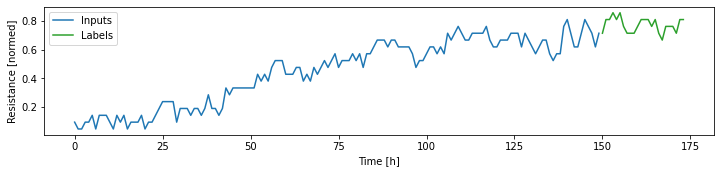

In [20]:
OUT_STEPS = 24

multi_window = WindowGenerator(input_width=150,
                              label_width=OUT_STEPS,
                              shift=OUT_STEPS)

multi_window.plot()
multi_window

In [21]:
MAX_EPOCHS = 2000

def compile_and_fit(model, window, patience=500):
    early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss',
                                                        patience=patience,
                                                        mode='min')

    model.compile(loss=tf.losses.MeanSquaredError(),
                    # optimizer=tf.optimizers.Adam(),
                    optimizer=Adam,
                    metrics=[tf.metrics.MeanAbsoluteError()])

    history = model.fit(window.train, epochs=MAX_EPOCHS,
                        validation_data=window.val,
                        callbacks=[early_stopping])
    return history

In [22]:
model = tf.keras.Sequential([
    # Shape [batch, time, features] => [batch, lstm_units]
    # Adding more `lstm_units` just overfits more quickly.
    tf.keras.layers.LSTM(32, return_sequences=False),
    # tf.keras.layers.LSTM(32, activation='relu', kernel_initializer='he_normal', dropout=0.1, return_sequences=False),
    # tf.keras.layers.Dropout(rate=0.2),
    # Shape => [batch, out_steps*features]
    tf.keras.layers.Dense(OUT_STEPS*num_features,
                          kernel_initializer=tf.initializers.zeros),
    # Shape => [batch, out_steps, features]
    tf.keras.layers.Reshape([OUT_STEPS, num_features])
])

In [23]:
history = compile_and_fit(model, multi_window)

Epoch 1/2000
1/1 [==============================] - 5s 5s/step - loss: 0.3476 - mean_absolute_error: 0.4794
Epoch 2/2000
1/1 [==============================] - 0s 103ms/step - loss: 0.3441 - mean_absolute_error: 0.4770
Epoch 3/2000
1/1 [==============================] - 0s 105ms/step - loss: 0.3404 - mean_absolute_error: 0.4744
Epoch 4/2000
1/1 [==============================] - 0s 103ms/step - loss: 0.3364 - mean_absolute_error: 0.4716
Epoch 5/2000
1/1 [==============================] - 0s 105ms/step - loss: 0.3320 - mean_absolute_error: 0.4685
Epoch 6/2000
1/1 [==============================] - 0s 99ms/step - loss: 0.3272 - mean_absolute_error: 0.4650
Epoch 7/2000
1/1 [==============================] - 0s 102ms/step - loss: 0.3220 - mean_absolute_error: 0.4612
Epoch 8/2000
1/1 [==============================] - 0s 96ms/step - loss: 0.3161 - mean_absolute_error: 0.4570
Epoch 9/2000
1/1 [==============================] - 0s 100ms/step - loss: 0.3096 - mean_absolute_error: 0.4522
Epoch 

Epoch 34/2000
1/1 [==============================] - 0s 109ms/step - loss: 0.0032 - mean_absolute_error: 0.0419
Epoch 35/2000
1/1 [==============================] - 0s 108ms/step - loss: 0.0045 - mean_absolute_error: 0.0494
Epoch 36/2000
1/1 [==============================] - 0s 112ms/step - loss: 0.0062 - mean_absolute_error: 0.0576
Epoch 37/2000
1/1 [==============================] - 0s 102ms/step - loss: 0.0078 - mean_absolute_error: 0.0661
Epoch 38/2000
1/1 [==============================] - 0s 110ms/step - loss: 0.0091 - mean_absolute_error: 0.0725
Epoch 39/2000
1/1 [==============================] - 0s 106ms/step - loss: 0.0100 - mean_absolute_error: 0.0770
Epoch 40/2000
1/1 [==============================] - 0s 101ms/step - loss: 0.0105 - mean_absolute_error: 0.0792
Epoch 41/2000
1/1 [==============================] - 0s 106ms/step - loss: 0.0104 - mean_absolute_error: 0.0794
Epoch 42/2000
1/1 [==============================] - 0s 103ms/step - loss: 0.0099 - mean_absolute_error:

Epoch 67/2000
1/1 [==============================] - 0s 98ms/step - loss: 0.0015 - mean_absolute_error: 0.0275
Epoch 68/2000
1/1 [==============================] - 0s 95ms/step - loss: 0.0014 - mean_absolute_error: 0.0257
Epoch 69/2000
1/1 [==============================] - 0s 96ms/step - loss: 0.0012 - mean_absolute_error: 0.0238
Epoch 70/2000
1/1 [==============================] - 0s 99ms/step - loss: 0.0011 - mean_absolute_error: 0.0218
Epoch 71/2000
1/1 [==============================] - 0s 102ms/step - loss: 0.0010 - mean_absolute_error: 0.0199
Epoch 72/2000
1/1 [==============================] - 0s 100ms/step - loss: 9.7472e-04 - mean_absolute_error: 0.0180
Epoch 73/2000
1/1 [==============================] - 0s 99ms/step - loss: 9.3099e-04 - mean_absolute_error: 0.0162
Epoch 74/2000
1/1 [==============================] - 0s 103ms/step - loss: 9.0876e-04 - mean_absolute_error: 0.0150
Epoch 75/2000
1/1 [==============================] - 0s 100ms/step - loss: 9.0482e-04 - mean_abso

1/1 [==============================] - 0s 113ms/step - loss: 8.8865e-04 - mean_absolute_error: 0.0144
Epoch 132/2000
1/1 [==============================] - 0s 99ms/step - loss: 8.8870e-04 - mean_absolute_error: 0.0144
Epoch 133/2000
1/1 [==============================] - 0s 104ms/step - loss: 8.8878e-04 - mean_absolute_error: 0.0145
Epoch 134/2000
1/1 [==============================] - 0s 104ms/step - loss: 8.8887e-04 - mean_absolute_error: 0.0145
Epoch 135/2000
1/1 [==============================] - 0s 101ms/step - loss: 8.8895e-04 - mean_absolute_error: 0.0145
Epoch 136/2000
1/1 [==============================] - 0s 105ms/step - loss: 8.8902e-04 - mean_absolute_error: 0.0146
Epoch 137/2000
1/1 [==============================] - 0s 99ms/step - loss: 8.8905e-04 - mean_absolute_error: 0.0146
Epoch 138/2000
1/1 [==============================] - 0s 105ms/step - loss: 8.8905e-04 - mean_absolute_error: 0.0146
Epoch 139/2000
1/1 [==============================] - 0s 101ms/step - loss: 8.890

1/1 [==============================] - 0s 98ms/step - loss: 8.8855e-04 - mean_absolute_error: 0.0144
Epoch 196/2000
1/1 [==============================] - 0s 94ms/step - loss: 8.8855e-04 - mean_absolute_error: 0.0144
Epoch 197/2000
1/1 [==============================] - 0s 99ms/step - loss: 8.8855e-04 - mean_absolute_error: 0.0144
Epoch 198/2000
1/1 [==============================] - 0s 99ms/step - loss: 8.8855e-04 - mean_absolute_error: 0.0144
Epoch 199/2000
1/1 [==============================] - 0s 100ms/step - loss: 8.8855e-04 - mean_absolute_error: 0.0144
Epoch 200/2000
1/1 [==============================] - 0s 102ms/step - loss: 8.8855e-04 - mean_absolute_error: 0.0144
Epoch 201/2000
1/1 [==============================] - 0s 105ms/step - loss: 8.8855e-04 - mean_absolute_error: 0.0144
Epoch 202/2000
1/1 [==============================] - 0s 96ms/step - loss: 8.8855e-04 - mean_absolute_error: 0.0144
Epoch 203/2000
1/1 [==============================] - 0s 93ms/step - loss: 8.8855e-0

1/1 [==============================] - 0s 94ms/step - loss: 8.8851e-04 - mean_absolute_error: 0.0144
Epoch 260/2000
1/1 [==============================] - 0s 95ms/step - loss: 8.8851e-04 - mean_absolute_error: 0.0144
Epoch 261/2000
1/1 [==============================] - 0s 95ms/step - loss: 8.8850e-04 - mean_absolute_error: 0.0144
Epoch 262/2000
1/1 [==============================] - 0s 95ms/step - loss: 8.8850e-04 - mean_absolute_error: 0.0144
Epoch 263/2000
1/1 [==============================] - 0s 103ms/step - loss: 8.8850e-04 - mean_absolute_error: 0.0144
Epoch 264/2000
1/1 [==============================] - 0s 99ms/step - loss: 8.8850e-04 - mean_absolute_error: 0.0144
Epoch 265/2000
1/1 [==============================] - 0s 104ms/step - loss: 8.8850e-04 - mean_absolute_error: 0.0144
Epoch 266/2000
1/1 [==============================] - 0s 99ms/step - loss: 8.8850e-04 - mean_absolute_error: 0.0144
Epoch 267/2000
1/1 [==============================] - 0s 102ms/step - loss: 8.8850e-0

1/1 [==============================] - 0s 109ms/step - loss: 8.8845e-04 - mean_absolute_error: 0.0144
Epoch 324/2000
1/1 [==============================] - 0s 106ms/step - loss: 8.8845e-04 - mean_absolute_error: 0.0144
Epoch 325/2000
1/1 [==============================] - 0s 116ms/step - loss: 8.8845e-04 - mean_absolute_error: 0.0144
Epoch 326/2000
1/1 [==============================] - 0s 101ms/step - loss: 8.8845e-04 - mean_absolute_error: 0.0144
Epoch 327/2000
1/1 [==============================] - 0s 96ms/step - loss: 8.8845e-04 - mean_absolute_error: 0.0144
Epoch 328/2000
1/1 [==============================] - 0s 104ms/step - loss: 8.8845e-04 - mean_absolute_error: 0.0144
Epoch 329/2000
1/1 [==============================] - 0s 103ms/step - loss: 8.8844e-04 - mean_absolute_error: 0.0144
Epoch 330/2000
1/1 [==============================] - 0s 98ms/step - loss: 8.8844e-04 - mean_absolute_error: 0.0144
Epoch 331/2000
1/1 [==============================] - 0s 101ms/step - loss: 8.884

1/1 [==============================] - 0s 95ms/step - loss: 8.8839e-04 - mean_absolute_error: 0.0144
Epoch 388/2000
1/1 [==============================] - 0s 95ms/step - loss: 8.8839e-04 - mean_absolute_error: 0.0144
Epoch 389/2000
1/1 [==============================] - 0s 94ms/step - loss: 8.8839e-04 - mean_absolute_error: 0.0144
Epoch 390/2000
1/1 [==============================] - 0s 97ms/step - loss: 8.8839e-04 - mean_absolute_error: 0.0144
Epoch 391/2000
1/1 [==============================] - 0s 96ms/step - loss: 8.8838e-04 - mean_absolute_error: 0.0144
Epoch 392/2000
1/1 [==============================] - 0s 98ms/step - loss: 8.8838e-04 - mean_absolute_error: 0.0144
Epoch 393/2000
1/1 [==============================] - 0s 101ms/step - loss: 8.8838e-04 - mean_absolute_error: 0.0144
Epoch 394/2000
1/1 [==============================] - 0s 101ms/step - loss: 8.8838e-04 - mean_absolute_error: 0.0144
Epoch 395/2000
1/1 [==============================] - 0s 97ms/step - loss: 8.8838e-04

1/1 [==============================] - 0s 96ms/step - loss: 8.8832e-04 - mean_absolute_error: 0.0144
Epoch 452/2000
1/1 [==============================] - 0s 99ms/step - loss: 8.8832e-04 - mean_absolute_error: 0.0144
Epoch 453/2000
1/1 [==============================] - 0s 100ms/step - loss: 8.8832e-04 - mean_absolute_error: 0.0144
Epoch 454/2000
1/1 [==============================] - 0s 101ms/step - loss: 8.8832e-04 - mean_absolute_error: 0.0144
Epoch 455/2000
1/1 [==============================] - 0s 100ms/step - loss: 8.8832e-04 - mean_absolute_error: 0.0144
Epoch 456/2000
1/1 [==============================] - 0s 97ms/step - loss: 8.8831e-04 - mean_absolute_error: 0.0144
Epoch 457/2000
1/1 [==============================] - 0s 97ms/step - loss: 8.8831e-04 - mean_absolute_error: 0.0144
Epoch 458/2000
1/1 [==============================] - 0s 94ms/step - loss: 8.8831e-04 - mean_absolute_error: 0.0144
Epoch 459/2000
1/1 [==============================] - 0s 101ms/step - loss: 8.8831e-

1/1 [==============================] - 0s 109ms/step - loss: 8.8824e-04 - mean_absolute_error: 0.0144
Epoch 516/2000
1/1 [==============================] - 0s 100ms/step - loss: 8.8824e-04 - mean_absolute_error: 0.0144
Epoch 517/2000
1/1 [==============================] - 0s 101ms/step - loss: 8.8824e-04 - mean_absolute_error: 0.0144
Epoch 518/2000
1/1 [==============================] - 0s 98ms/step - loss: 8.8824e-04 - mean_absolute_error: 0.0144
Epoch 519/2000
1/1 [==============================] - 0s 106ms/step - loss: 8.8824e-04 - mean_absolute_error: 0.0144
Epoch 520/2000
1/1 [==============================] - 0s 101ms/step - loss: 8.8824e-04 - mean_absolute_error: 0.0144
Epoch 521/2000
1/1 [==============================] - 0s 102ms/step - loss: 8.8824e-04 - mean_absolute_error: 0.0144
Epoch 522/2000
1/1 [==============================] - 0s 103ms/step - loss: 8.8824e-04 - mean_absolute_error: 0.0144
Epoch 523/2000
1/1 [==============================] - 0s 103ms/step - loss: 8.88

1/1 [==============================] - 0s 97ms/step - loss: 8.8816e-04 - mean_absolute_error: 0.0144
Epoch 580/2000
1/1 [==============================] - 0s 96ms/step - loss: 8.8816e-04 - mean_absolute_error: 0.0144
Epoch 581/2000
1/1 [==============================] - 0s 101ms/step - loss: 8.8816e-04 - mean_absolute_error: 0.0144
Epoch 582/2000
1/1 [==============================] - 0s 98ms/step - loss: 8.8816e-04 - mean_absolute_error: 0.0144
Epoch 583/2000
1/1 [==============================] - 0s 96ms/step - loss: 8.8816e-04 - mean_absolute_error: 0.0144
Epoch 584/2000
1/1 [==============================] - 0s 98ms/step - loss: 8.8816e-04 - mean_absolute_error: 0.0144
Epoch 585/2000
1/1 [==============================] - 0s 97ms/step - loss: 8.8816e-04 - mean_absolute_error: 0.0144
Epoch 586/2000
1/1 [==============================] - 0s 96ms/step - loss: 8.8815e-04 - mean_absolute_error: 0.0144
Epoch 587/2000
1/1 [==============================] - 0s 94ms/step - loss: 8.8815e-04 

1/1 [==============================] - 0s 98ms/step - loss: 8.8808e-04 - mean_absolute_error: 0.0144
Epoch 644/2000
1/1 [==============================] - 0s 97ms/step - loss: 8.8807e-04 - mean_absolute_error: 0.0144
Epoch 645/2000
1/1 [==============================] - 0s 98ms/step - loss: 8.8807e-04 - mean_absolute_error: 0.0144
Epoch 646/2000
1/1 [==============================] - 0s 107ms/step - loss: 8.8807e-04 - mean_absolute_error: 0.0144
Epoch 647/2000
1/1 [==============================] - 0s 101ms/step - loss: 8.8807e-04 - mean_absolute_error: 0.0144
Epoch 648/2000
1/1 [==============================] - 0s 103ms/step - loss: 8.8807e-04 - mean_absolute_error: 0.0144
Epoch 649/2000
1/1 [==============================] - 0s 102ms/step - loss: 8.8807e-04 - mean_absolute_error: 0.0144
Epoch 650/2000
1/1 [==============================] - 0s 104ms/step - loss: 8.8807e-04 - mean_absolute_error: 0.0144
Epoch 651/2000
1/1 [==============================] - 0s 104ms/step - loss: 8.8806

1/1 [==============================] - 0s 107ms/step - loss: 8.8798e-04 - mean_absolute_error: 0.0144
Epoch 708/2000
1/1 [==============================] - 0s 99ms/step - loss: 8.8798e-04 - mean_absolute_error: 0.0144
Epoch 709/2000
1/1 [==============================] - 0s 115ms/step - loss: 8.8798e-04 - mean_absolute_error: 0.0144
Epoch 710/2000
1/1 [==============================] - 0s 119ms/step - loss: 8.8798e-04 - mean_absolute_error: 0.0144
Epoch 711/2000
1/1 [==============================] - 0s 105ms/step - loss: 8.8798e-04 - mean_absolute_error: 0.0144
Epoch 712/2000
1/1 [==============================] - 0s 103ms/step - loss: 8.8797e-04 - mean_absolute_error: 0.0144
Epoch 713/2000
1/1 [==============================] - 0s 100ms/step - loss: 8.8797e-04 - mean_absolute_error: 0.0144
Epoch 714/2000
1/1 [==============================] - 0s 104ms/step - loss: 8.8797e-04 - mean_absolute_error: 0.0144
Epoch 715/2000
1/1 [==============================] - 0s 107ms/step - loss: 8.87

1/1 [==============================] - 0s 103ms/step - loss: 8.8788e-04 - mean_absolute_error: 0.0144
Epoch 772/2000
1/1 [==============================] - 0s 102ms/step - loss: 8.8788e-04 - mean_absolute_error: 0.0144
Epoch 773/2000
1/1 [==============================] - 0s 98ms/step - loss: 8.8788e-04 - mean_absolute_error: 0.0144
Epoch 774/2000
1/1 [==============================] - 0s 98ms/step - loss: 8.8788e-04 - mean_absolute_error: 0.0144
Epoch 775/2000
1/1 [==============================] - 0s 109ms/step - loss: 8.8788e-04 - mean_absolute_error: 0.0144
Epoch 776/2000
1/1 [==============================] - 0s 104ms/step - loss: 8.8787e-04 - mean_absolute_error: 0.0144
Epoch 777/2000
1/1 [==============================] - 0s 104ms/step - loss: 8.8787e-04 - mean_absolute_error: 0.0144
Epoch 778/2000
1/1 [==============================] - 0s 105ms/step - loss: 8.8787e-04 - mean_absolute_error: 0.0144
Epoch 779/2000
1/1 [==============================] - 0s 94ms/step - loss: 8.8787

Epoch 835/2000
1/1 [==============================] - 0s 101ms/step - loss: 8.8778e-04 - mean_absolute_error: 0.0144
Epoch 836/2000
1/1 [==============================] - 0s 113ms/step - loss: 8.8777e-04 - mean_absolute_error: 0.0144
Epoch 837/2000
1/1 [==============================] - 0s 113ms/step - loss: 8.8777e-04 - mean_absolute_error: 0.0144
Epoch 838/2000
1/1 [==============================] - 0s 102ms/step - loss: 8.8777e-04 - mean_absolute_error: 0.0144
Epoch 839/2000
1/1 [==============================] - 0s 144ms/step - loss: 8.8777e-04 - mean_absolute_error: 0.0144
Epoch 840/2000
1/1 [==============================] - 0s 103ms/step - loss: 8.8777e-04 - mean_absolute_error: 0.0144
Epoch 841/2000
1/1 [==============================] - 0s 112ms/step - loss: 8.8777e-04 - mean_absolute_error: 0.0144
Epoch 842/2000
1/1 [==============================] - 0s 105ms/step - loss: 8.8776e-04 - mean_absolute_error: 0.0144
Epoch 843/2000
1/1 [==============================] - 0s 105ms/s

1/1 [==============================] - 0s 102ms/step - loss: 8.8772e-04 - mean_absolute_error: 0.0144
Epoch 868/2000
1/1 [==============================] - 0s 99ms/step - loss: 8.8772e-04 - mean_absolute_error: 0.0144
Epoch 869/2000
1/1 [==============================] - 0s 106ms/step - loss: 8.8772e-04 - mean_absolute_error: 0.0144
Epoch 870/2000
1/1 [==============================] - 0s 104ms/step - loss: 8.8771e-04 - mean_absolute_error: 0.0144
Epoch 871/2000
1/1 [==============================] - 0s 106ms/step - loss: 8.8771e-04 - mean_absolute_error: 0.0144
Epoch 872/2000
1/1 [==============================] - 0s 104ms/step - loss: 8.8771e-04 - mean_absolute_error: 0.0144
Epoch 873/2000
1/1 [==============================] - 0s 105ms/step - loss: 8.8771e-04 - mean_absolute_error: 0.0144
Epoch 874/2000
1/1 [==============================] - 0s 103ms/step - loss: 8.8771e-04 - mean_absolute_error: 0.0144
Epoch 875/2000
1/1 [==============================] - 0s 101ms/step - loss: 8.87

1/1 [==============================] - 0s 100ms/step - loss: 8.8760e-04 - mean_absolute_error: 0.0144
Epoch 932/2000
1/1 [==============================] - 0s 104ms/step - loss: 8.8760e-04 - mean_absolute_error: 0.0144
Epoch 933/2000
1/1 [==============================] - 0s 104ms/step - loss: 8.8760e-04 - mean_absolute_error: 0.0144
Epoch 934/2000
1/1 [==============================] - 0s 102ms/step - loss: 8.8760e-04 - mean_absolute_error: 0.0144
Epoch 935/2000
1/1 [==============================] - 0s 96ms/step - loss: 8.8760e-04 - mean_absolute_error: 0.0144
Epoch 936/2000
1/1 [==============================] - 0s 104ms/step - loss: 8.8759e-04 - mean_absolute_error: 0.0144
Epoch 937/2000
1/1 [==============================] - 0s 96ms/step - loss: 8.8759e-04 - mean_absolute_error: 0.0144
Epoch 938/2000
1/1 [==============================] - 0s 103ms/step - loss: 8.8759e-04 - mean_absolute_error: 0.0144
Epoch 939/2000
1/1 [==============================] - 0s 95ms/step - loss: 8.8759

1/1 [==============================] - 0s 104ms/step - loss: 8.8748e-04 - mean_absolute_error: 0.0144
Epoch 996/2000
1/1 [==============================] - 0s 103ms/step - loss: 8.8748e-04 - mean_absolute_error: 0.0144
Epoch 997/2000
1/1 [==============================] - 0s 100ms/step - loss: 8.8748e-04 - mean_absolute_error: 0.0144
Epoch 998/2000
1/1 [==============================] - 0s 103ms/step - loss: 8.8747e-04 - mean_absolute_error: 0.0144
Epoch 999/2000
1/1 [==============================] - 0s 96ms/step - loss: 8.8747e-04 - mean_absolute_error: 0.0144
Epoch 1000/2000
1/1 [==============================] - 0s 99ms/step - loss: 8.8747e-04 - mean_absolute_error: 0.0144
Epoch 1001/2000
1/1 [==============================] - 0s 96ms/step - loss: 8.8747e-04 - mean_absolute_error: 0.0144
Epoch 1002/2000
1/1 [==============================] - 0s 99ms/step - loss: 8.8747e-04 - mean_absolute_error: 0.0144
Epoch 1003/2000
1/1 [==============================] - 0s 109ms/step - loss: 8.8

1/1 [==============================] - 0s 99ms/step - loss: 8.8742e-04 - mean_absolute_error: 0.0144
Epoch 1028/2000
1/1 [==============================] - 0s 98ms/step - loss: 8.8741e-04 - mean_absolute_error: 0.0144
Epoch 1029/2000
1/1 [==============================] - 0s 105ms/step - loss: 8.8741e-04 - mean_absolute_error: 0.0144
Epoch 1030/2000
1/1 [==============================] - 0s 96ms/step - loss: 8.8741e-04 - mean_absolute_error: 0.0144
Epoch 1031/2000
1/1 [==============================] - 0s 105ms/step - loss: 8.8741e-04 - mean_absolute_error: 0.0144
Epoch 1032/2000
1/1 [==============================] - 0s 101ms/step - loss: 8.8741e-04 - mean_absolute_error: 0.0144
Epoch 1033/2000
1/1 [==============================] - 0s 96ms/step - loss: 8.8740e-04 - mean_absolute_error: 0.0144
Epoch 1034/2000
1/1 [==============================] - 0s 97ms/step - loss: 8.8740e-04 - mean_absolute_error: 0.0144
Epoch 1035/2000
1/1 [==============================] - 0s 103ms/step - loss: 

1/1 [==============================] - 0s 96ms/step - loss: 8.8735e-04 - mean_absolute_error: 0.0144
Epoch 1060/2000
1/1 [==============================] - 0s 97ms/step - loss: 8.8735e-04 - mean_absolute_error: 0.0144
Epoch 1061/2000
1/1 [==============================] - 0s 114ms/step - loss: 8.8735e-04 - mean_absolute_error: 0.0144
Epoch 1062/2000
1/1 [==============================] - 0s 96ms/step - loss: 8.8734e-04 - mean_absolute_error: 0.0144
Epoch 1063/2000
1/1 [==============================] - 0s 101ms/step - loss: 8.8734e-04 - mean_absolute_error: 0.0144
Epoch 1064/2000
1/1 [==============================] - 0s 101ms/step - loss: 8.8734e-04 - mean_absolute_error: 0.0144
Epoch 1065/2000
1/1 [==============================] - 0s 99ms/step - loss: 8.8734e-04 - mean_absolute_error: 0.0144
Epoch 1066/2000
1/1 [==============================] - 0s 98ms/step - loss: 8.8734e-04 - mean_absolute_error: 0.0144
Epoch 1067/2000
1/1 [==============================] - 0s 97ms/step - loss: 8

Epoch 1091/2000
1/1 [==============================] - 0s 104ms/step - loss: 8.8728e-04 - mean_absolute_error: 0.0144
Epoch 1092/2000
1/1 [==============================] - 0s 104ms/step - loss: 8.8728e-04 - mean_absolute_error: 0.0144
Epoch 1093/2000
1/1 [==============================] - 0s 104ms/step - loss: 8.8728e-04 - mean_absolute_error: 0.0144
Epoch 1094/2000
1/1 [==============================] - 0s 99ms/step - loss: 8.8728e-04 - mean_absolute_error: 0.0144
Epoch 1095/2000
1/1 [==============================] - 0s 113ms/step - loss: 8.8728e-04 - mean_absolute_error: 0.0144
Epoch 1096/2000
1/1 [==============================] - 0s 99ms/step - loss: 8.8727e-04 - mean_absolute_error: 0.0144
Epoch 1097/2000
1/1 [==============================] - 0s 113ms/step - loss: 8.8727e-04 - mean_absolute_error: 0.0144
Epoch 1098/2000
1/1 [==============================] - 0s 107ms/step - loss: 8.8727e-04 - mean_absolute_error: 0.0144
Epoch 1099/2000
1/1 [==============================] - 0s 

Epoch 1123/2000
1/1 [==============================] - 0s 102ms/step - loss: 8.8721e-04 - mean_absolute_error: 0.0144
Epoch 1124/2000
1/1 [==============================] - 0s 98ms/step - loss: 8.8721e-04 - mean_absolute_error: 0.0144
Epoch 1125/2000
1/1 [==============================] - 0s 103ms/step - loss: 8.8721e-04 - mean_absolute_error: 0.0144
Epoch 1126/2000
1/1 [==============================] - 0s 97ms/step - loss: 8.8721e-04 - mean_absolute_error: 0.0144
Epoch 1127/2000
1/1 [==============================] - 0s 101ms/step - loss: 8.8721e-04 - mean_absolute_error: 0.0144
Epoch 1128/2000
1/1 [==============================] - 0s 100ms/step - loss: 8.8720e-04 - mean_absolute_error: 0.0144
Epoch 1129/2000
1/1 [==============================] - 0s 97ms/step - loss: 8.8720e-04 - mean_absolute_error: 0.0144
Epoch 1130/2000
1/1 [==============================] - 0s 95ms/step - loss: 8.8720e-04 - mean_absolute_error: 0.0144
Epoch 1131/2000
1/1 [==============================] - 0s 10

Epoch 1155/2000
1/1 [==============================] - 0s 106ms/step - loss: 8.8714e-04 - mean_absolute_error: 0.0144
Epoch 1156/2000
1/1 [==============================] - 0s 98ms/step - loss: 8.8714e-04 - mean_absolute_error: 0.0144
Epoch 1157/2000
1/1 [==============================] - 0s 97ms/step - loss: 8.8714e-04 - mean_absolute_error: 0.0144
Epoch 1158/2000
1/1 [==============================] - 0s 96ms/step - loss: 8.8714e-04 - mean_absolute_error: 0.0144
Epoch 1159/2000
1/1 [==============================] - 0s 98ms/step - loss: 8.8713e-04 - mean_absolute_error: 0.0144
Epoch 1160/2000
1/1 [==============================] - 0s 97ms/step - loss: 8.8713e-04 - mean_absolute_error: 0.0144
Epoch 1161/2000
1/1 [==============================] - 0s 97ms/step - loss: 8.8713e-04 - mean_absolute_error: 0.0144
Epoch 1162/2000
1/1 [==============================] - 0s 104ms/step - loss: 8.8713e-04 - mean_absolute_error: 0.0144
Epoch 1163/2000
1/1 [==============================] - 0s 99ms

Epoch 1187/2000
1/1 [==============================] - 0s 112ms/step - loss: 8.8707e-04 - mean_absolute_error: 0.0144
Epoch 1188/2000
1/1 [==============================] - 0s 111ms/step - loss: 8.8707e-04 - mean_absolute_error: 0.0144
Epoch 1189/2000
1/1 [==============================] - 0s 102ms/step - loss: 8.8707e-04 - mean_absolute_error: 0.0144
Epoch 1190/2000
1/1 [==============================] - 0s 101ms/step - loss: 8.8706e-04 - mean_absolute_error: 0.0144
Epoch 1191/2000
1/1 [==============================] - 0s 143ms/step - loss: 8.8706e-04 - mean_absolute_error: 0.0144
Epoch 1192/2000
1/1 [==============================] - 0s 106ms/step - loss: 8.8706e-04 - mean_absolute_error: 0.0144
Epoch 1193/2000
1/1 [==============================] - 0s 115ms/step - loss: 8.8706e-04 - mean_absolute_error: 0.0144
Epoch 1194/2000
1/1 [==============================] - 0s 102ms/step - loss: 8.8705e-04 - mean_absolute_error: 0.0144
Epoch 1195/2000
1/1 [==============================] - 0

Epoch 1219/2000
1/1 [==============================] - 0s 111ms/step - loss: 8.8700e-04 - mean_absolute_error: 0.0144
Epoch 1220/2000
1/1 [==============================] - 0s 115ms/step - loss: 8.8699e-04 - mean_absolute_error: 0.0144
Epoch 1221/2000
1/1 [==============================] - 0s 103ms/step - loss: 8.8699e-04 - mean_absolute_error: 0.0144
Epoch 1222/2000
1/1 [==============================] - 0s 99ms/step - loss: 8.8699e-04 - mean_absolute_error: 0.0144
Epoch 1223/2000
1/1 [==============================] - 0s 94ms/step - loss: 8.8699e-04 - mean_absolute_error: 0.0144
Epoch 1224/2000
1/1 [==============================] - 0s 101ms/step - loss: 8.8698e-04 - mean_absolute_error: 0.0144
Epoch 1225/2000
1/1 [==============================] - 0s 98ms/step - loss: 8.8698e-04 - mean_absolute_error: 0.0144
Epoch 1226/2000
1/1 [==============================] - 0s 97ms/step - loss: 8.8698e-04 - mean_absolute_error: 0.0144
Epoch 1227/2000
1/1 [==============================] - 0s 10

Epoch 1251/2000
1/1 [==============================] - 0s 112ms/step - loss: 8.8692e-04 - mean_absolute_error: 0.0144
Epoch 1252/2000
1/1 [==============================] - 0s 111ms/step - loss: 8.8692e-04 - mean_absolute_error: 0.0144
Epoch 1253/2000
1/1 [==============================] - 0s 135ms/step - loss: 8.8691e-04 - mean_absolute_error: 0.0144
Epoch 1254/2000
1/1 [==============================] - 0s 118ms/step - loss: 8.8691e-04 - mean_absolute_error: 0.0144
Epoch 1255/2000
1/1 [==============================] - 0s 108ms/step - loss: 8.8691e-04 - mean_absolute_error: 0.0144
Epoch 1256/2000
1/1 [==============================] - 0s 112ms/step - loss: 8.8691e-04 - mean_absolute_error: 0.0144
Epoch 1257/2000
1/1 [==============================] - 0s 122ms/step - loss: 8.8690e-04 - mean_absolute_error: 0.0144
Epoch 1258/2000
1/1 [==============================] - 0s 118ms/step - loss: 8.8690e-04 - mean_absolute_error: 0.0144
Epoch 1259/2000
1/1 [==============================] - 0

Epoch 1283/2000
1/1 [==============================] - 0s 102ms/step - loss: 8.8684e-04 - mean_absolute_error: 0.0144
Epoch 1284/2000
1/1 [==============================] - 0s 99ms/step - loss: 8.8684e-04 - mean_absolute_error: 0.0144
Epoch 1285/2000
1/1 [==============================] - 0s 95ms/step - loss: 8.8683e-04 - mean_absolute_error: 0.0144
Epoch 1286/2000
1/1 [==============================] - 0s 102ms/step - loss: 8.8683e-04 - mean_absolute_error: 0.0144
Epoch 1287/2000
1/1 [==============================] - 0s 97ms/step - loss: 8.8683e-04 - mean_absolute_error: 0.0144
Epoch 1288/2000
1/1 [==============================] - 0s 104ms/step - loss: 8.8683e-04 - mean_absolute_error: 0.0144
Epoch 1289/2000
1/1 [==============================] - 0s 108ms/step - loss: 8.8682e-04 - mean_absolute_error: 0.0144
Epoch 1290/2000
1/1 [==============================] - 0s 96ms/step - loss: 8.8682e-04 - mean_absolute_error: 0.0144
Epoch 1291/2000
1/1 [==============================] - 0s 93

Epoch 1315/2000
1/1 [==============================] - 0s 97ms/step - loss: 8.8676e-04 - mean_absolute_error: 0.0144
Epoch 1316/2000
1/1 [==============================] - 0s 94ms/step - loss: 8.8676e-04 - mean_absolute_error: 0.0144
Epoch 1317/2000
1/1 [==============================] - 0s 96ms/step - loss: 8.8675e-04 - mean_absolute_error: 0.0144
Epoch 1318/2000
1/1 [==============================] - 0s 97ms/step - loss: 8.8675e-04 - mean_absolute_error: 0.0144
Epoch 1319/2000
1/1 [==============================] - 0s 98ms/step - loss: 8.8675e-04 - mean_absolute_error: 0.0144
Epoch 1320/2000
1/1 [==============================] - 0s 98ms/step - loss: 8.8675e-04 - mean_absolute_error: 0.0144
Epoch 1321/2000
1/1 [==============================] - 0s 97ms/step - loss: 8.8674e-04 - mean_absolute_error: 0.0144
Epoch 1322/2000
1/1 [==============================] - 0s 96ms/step - loss: 8.8674e-04 - mean_absolute_error: 0.0144
Epoch 1323/2000
1/1 [==============================] - 0s 95ms/s

Epoch 1347/2000
1/1 [==============================] - 0s 103ms/step - loss: 8.8668e-04 - mean_absolute_error: 0.0144
Epoch 1348/2000
1/1 [==============================] - 0s 118ms/step - loss: 8.8667e-04 - mean_absolute_error: 0.0144
Epoch 1349/2000
1/1 [==============================] - 0s 110ms/step - loss: 8.8667e-04 - mean_absolute_error: 0.0144
Epoch 1350/2000
1/1 [==============================] - 0s 113ms/step - loss: 8.8667e-04 - mean_absolute_error: 0.0144
Epoch 1351/2000
1/1 [==============================] - 0s 109ms/step - loss: 8.8666e-04 - mean_absolute_error: 0.0144
Epoch 1352/2000
1/1 [==============================] - 0s 99ms/step - loss: 8.8666e-04 - mean_absolute_error: 0.0144
Epoch 1353/2000
1/1 [==============================] - 0s 101ms/step - loss: 8.8666e-04 - mean_absolute_error: 0.0144
Epoch 1354/2000
1/1 [==============================] - 0s 112ms/step - loss: 8.8666e-04 - mean_absolute_error: 0.0144
Epoch 1355/2000
1/1 [==============================] - 0s

Epoch 1379/2000
1/1 [==============================] - 0s 103ms/step - loss: 8.8659e-04 - mean_absolute_error: 0.0144
Epoch 1380/2000
1/1 [==============================] - 0s 104ms/step - loss: 8.8659e-04 - mean_absolute_error: 0.0144
Epoch 1381/2000
1/1 [==============================] - 0s 96ms/step - loss: 8.8658e-04 - mean_absolute_error: 0.0144
Epoch 1382/2000
1/1 [==============================] - 0s 93ms/step - loss: 8.8658e-04 - mean_absolute_error: 0.0144
Epoch 1383/2000
1/1 [==============================] - 0s 109ms/step - loss: 8.8658e-04 - mean_absolute_error: 0.0144
Epoch 1384/2000
1/1 [==============================] - 0s 108ms/step - loss: 8.8658e-04 - mean_absolute_error: 0.0144
Epoch 1385/2000
1/1 [==============================] - 0s 96ms/step - loss: 8.8657e-04 - mean_absolute_error: 0.0144
Epoch 1386/2000
1/1 [==============================] - 0s 101ms/step - loss: 8.8657e-04 - mean_absolute_error: 0.0144
Epoch 1387/2000
1/1 [==============================] - 0s 1

Epoch 1411/2000
1/1 [==============================] - 0s 128ms/step - loss: 8.8650e-04 - mean_absolute_error: 0.0144
Epoch 1412/2000
1/1 [==============================] - 0s 109ms/step - loss: 8.8650e-04 - mean_absolute_error: 0.0144
Epoch 1413/2000
1/1 [==============================] - 0s 105ms/step - loss: 8.8650e-04 - mean_absolute_error: 0.0144
Epoch 1414/2000
1/1 [==============================] - 0s 118ms/step - loss: 8.8649e-04 - mean_absolute_error: 0.0144
Epoch 1415/2000
1/1 [==============================] - 0s 116ms/step - loss: 8.8649e-04 - mean_absolute_error: 0.0144
Epoch 1416/2000
1/1 [==============================] - 0s 107ms/step - loss: 8.8649e-04 - mean_absolute_error: 0.0144
Epoch 1417/2000
1/1 [==============================] - 0s 100ms/step - loss: 8.8649e-04 - mean_absolute_error: 0.0144
Epoch 1418/2000
1/1 [==============================] - 0s 96ms/step - loss: 8.8648e-04 - mean_absolute_error: 0.0144
Epoch 1419/2000
1/1 [==============================] - 0s

Epoch 1443/2000
1/1 [==============================] - 0s 113ms/step - loss: 8.8641e-04 - mean_absolute_error: 0.0144
Epoch 1444/2000
1/1 [==============================] - 0s 127ms/step - loss: 8.8641e-04 - mean_absolute_error: 0.0144
Epoch 1445/2000
1/1 [==============================] - 0s 109ms/step - loss: 8.8641e-04 - mean_absolute_error: 0.0144
Epoch 1446/2000
1/1 [==============================] - 0s 104ms/step - loss: 8.8640e-04 - mean_absolute_error: 0.0144
Epoch 1447/2000
1/1 [==============================] - 0s 113ms/step - loss: 8.8640e-04 - mean_absolute_error: 0.0144
Epoch 1448/2000
1/1 [==============================] - 0s 111ms/step - loss: 8.8640e-04 - mean_absolute_error: 0.0144
Epoch 1449/2000
1/1 [==============================] - 0s 127ms/step - loss: 8.8640e-04 - mean_absolute_error: 0.0144
Epoch 1450/2000
1/1 [==============================] - 0s 145ms/step - loss: 8.8639e-04 - mean_absolute_error: 0.0144
Epoch 1451/2000
1/1 [==============================] - 0

Epoch 1475/2000
1/1 [==============================] - 0s 100ms/step - loss: 8.8632e-04 - mean_absolute_error: 0.0144
Epoch 1476/2000
1/1 [==============================] - 0s 96ms/step - loss: 8.8632e-04 - mean_absolute_error: 0.0144
Epoch 1477/2000
1/1 [==============================] - 0s 101ms/step - loss: 8.8631e-04 - mean_absolute_error: 0.0144
Epoch 1478/2000
1/1 [==============================] - 0s 105ms/step - loss: 8.8631e-04 - mean_absolute_error: 0.0144
Epoch 1479/2000
1/1 [==============================] - 0s 106ms/step - loss: 8.8631e-04 - mean_absolute_error: 0.0144
Epoch 1480/2000
1/1 [==============================] - 0s 117ms/step - loss: 8.8631e-04 - mean_absolute_error: 0.0144
Epoch 1481/2000
1/1 [==============================] - 0s 98ms/step - loss: 8.8630e-04 - mean_absolute_error: 0.0144
Epoch 1482/2000
1/1 [==============================] - 0s 112ms/step - loss: 8.8630e-04 - mean_absolute_error: 0.0144
Epoch 1483/2000
1/1 [==============================] - 0s 

Epoch 1507/2000
1/1 [==============================] - 0s 98ms/step - loss: 8.8623e-04 - mean_absolute_error: 0.0144
Epoch 1508/2000
1/1 [==============================] - 0s 96ms/step - loss: 8.8622e-04 - mean_absolute_error: 0.0144
Epoch 1509/2000
1/1 [==============================] - 0s 99ms/step - loss: 8.8622e-04 - mean_absolute_error: 0.0144
Epoch 1510/2000
1/1 [==============================] - 0s 98ms/step - loss: 8.8622e-04 - mean_absolute_error: 0.0144
Epoch 1511/2000
1/1 [==============================] - 0s 94ms/step - loss: 8.8621e-04 - mean_absolute_error: 0.0144
Epoch 1512/2000
1/1 [==============================] - 0s 96ms/step - loss: 8.8621e-04 - mean_absolute_error: 0.0144
Epoch 1513/2000
1/1 [==============================] - 0s 98ms/step - loss: 8.8621e-04 - mean_absolute_error: 0.0144
Epoch 1514/2000
1/1 [==============================] - 0s 96ms/step - loss: 8.8620e-04 - mean_absolute_error: 0.0144
Epoch 1515/2000
1/1 [==============================] - 0s 97ms/s

Epoch 1539/2000
1/1 [==============================] - 0s 108ms/step - loss: 8.8613e-04 - mean_absolute_error: 0.0144
Epoch 1540/2000
1/1 [==============================] - 0s 101ms/step - loss: 8.8613e-04 - mean_absolute_error: 0.0144
Epoch 1541/2000
1/1 [==============================] - 0s 106ms/step - loss: 8.8612e-04 - mean_absolute_error: 0.0144
Epoch 1542/2000
1/1 [==============================] - 0s 102ms/step - loss: 8.8612e-04 - mean_absolute_error: 0.0144
Epoch 1543/2000
1/1 [==============================] - 0s 107ms/step - loss: 8.8612e-04 - mean_absolute_error: 0.0144
Epoch 1544/2000
1/1 [==============================] - 0s 104ms/step - loss: 8.8611e-04 - mean_absolute_error: 0.0144
Epoch 1545/2000
1/1 [==============================] - 0s 103ms/step - loss: 8.8611e-04 - mean_absolute_error: 0.0144
Epoch 1546/2000
1/1 [==============================] - 0s 106ms/step - loss: 8.8611e-04 - mean_absolute_error: 0.0144
Epoch 1547/2000
1/1 [==============================] - 0

Epoch 1571/2000
1/1 [==============================] - 0s 135ms/step - loss: 8.8603e-04 - mean_absolute_error: 0.0144
Epoch 1572/2000
1/1 [==============================] - 0s 141ms/step - loss: 8.8603e-04 - mean_absolute_error: 0.0144
Epoch 1573/2000
1/1 [==============================] - 0s 110ms/step - loss: 8.8602e-04 - mean_absolute_error: 0.0144
Epoch 1574/2000
1/1 [==============================] - 0s 106ms/step - loss: 8.8602e-04 - mean_absolute_error: 0.0144
Epoch 1575/2000
1/1 [==============================] - 0s 103ms/step - loss: 8.8602e-04 - mean_absolute_error: 0.0144
Epoch 1576/2000
1/1 [==============================] - 0s 108ms/step - loss: 8.8601e-04 - mean_absolute_error: 0.0144
Epoch 1577/2000
1/1 [==============================] - 0s 109ms/step - loss: 8.8601e-04 - mean_absolute_error: 0.0144
Epoch 1578/2000
1/1 [==============================] - 0s 104ms/step - loss: 8.8601e-04 - mean_absolute_error: 0.0144
Epoch 1579/2000
1/1 [==============================] - 0

Epoch 1603/2000
1/1 [==============================] - 0s 102ms/step - loss: 8.8593e-04 - mean_absolute_error: 0.0144
Epoch 1604/2000
1/1 [==============================] - 0s 108ms/step - loss: 8.8592e-04 - mean_absolute_error: 0.0144
Epoch 1605/2000
1/1 [==============================] - 0s 107ms/step - loss: 8.8592e-04 - mean_absolute_error: 0.0144
Epoch 1606/2000
1/1 [==============================] - 0s 106ms/step - loss: 8.8592e-04 - mean_absolute_error: 0.0144
Epoch 1607/2000
1/1 [==============================] - 0s 101ms/step - loss: 8.8591e-04 - mean_absolute_error: 0.0144
Epoch 1608/2000
1/1 [==============================] - 0s 112ms/step - loss: 8.8591e-04 - mean_absolute_error: 0.0144
Epoch 1609/2000
1/1 [==============================] - 0s 99ms/step - loss: 8.8591e-04 - mean_absolute_error: 0.0144
Epoch 1610/2000
1/1 [==============================] - 0s 102ms/step - loss: 8.8591e-04 - mean_absolute_error: 0.0144
Epoch 1611/2000
1/1 [==============================] - 0s

Epoch 1635/2000
1/1 [==============================] - 0s 119ms/step - loss: 8.8582e-04 - mean_absolute_error: 0.0144
Epoch 1636/2000
1/1 [==============================] - 0s 117ms/step - loss: 8.8582e-04 - mean_absolute_error: 0.0144
Epoch 1637/2000
1/1 [==============================] - 0s 107ms/step - loss: 8.8582e-04 - mean_absolute_error: 0.0144
Epoch 1638/2000
1/1 [==============================] - 0s 102ms/step - loss: 8.8581e-04 - mean_absolute_error: 0.0144
Epoch 1639/2000
1/1 [==============================] - 0s 100ms/step - loss: 8.8581e-04 - mean_absolute_error: 0.0144
Epoch 1640/2000
1/1 [==============================] - 0s 98ms/step - loss: 8.8581e-04 - mean_absolute_error: 0.0144
Epoch 1641/2000
1/1 [==============================] - 0s 101ms/step - loss: 8.8580e-04 - mean_absolute_error: 0.0144
Epoch 1642/2000
1/1 [==============================] - 0s 102ms/step - loss: 8.8580e-04 - mean_absolute_error: 0.0144
Epoch 1643/2000
1/1 [==============================] - 0s

Epoch 1667/2000
1/1 [==============================] - 0s 96ms/step - loss: 8.8572e-04 - mean_absolute_error: 0.0144
Epoch 1668/2000
1/1 [==============================] - 0s 96ms/step - loss: 8.8571e-04 - mean_absolute_error: 0.0144
Epoch 1669/2000
1/1 [==============================] - 0s 95ms/step - loss: 8.8571e-04 - mean_absolute_error: 0.0144
Epoch 1670/2000
1/1 [==============================] - 0s 99ms/step - loss: 8.8570e-04 - mean_absolute_error: 0.0144
Epoch 1671/2000
1/1 [==============================] - 0s 108ms/step - loss: 8.8570e-04 - mean_absolute_error: 0.0144
Epoch 1672/2000
1/1 [==============================] - 0s 102ms/step - loss: 8.8570e-04 - mean_absolute_error: 0.0144
Epoch 1673/2000
1/1 [==============================] - 0s 96ms/step - loss: 8.8569e-04 - mean_absolute_error: 0.0144
Epoch 1674/2000
1/1 [==============================] - 0s 98ms/step - loss: 8.8569e-04 - mean_absolute_error: 0.0144
Epoch 1675/2000
1/1 [==============================] - 0s 96ms

Epoch 1699/2000
1/1 [==============================] - 0s 97ms/step - loss: 8.8560e-04 - mean_absolute_error: 0.0144
Epoch 1700/2000
1/1 [==============================] - 0s 99ms/step - loss: 8.8560e-04 - mean_absolute_error: 0.0144
Epoch 1701/2000
1/1 [==============================] - 0s 99ms/step - loss: 8.8560e-04 - mean_absolute_error: 0.0144
Epoch 1702/2000
1/1 [==============================] - 0s 106ms/step - loss: 8.8559e-04 - mean_absolute_error: 0.0144
Epoch 1703/2000
1/1 [==============================] - 0s 110ms/step - loss: 8.8559e-04 - mean_absolute_error: 0.0144
Epoch 1704/2000
1/1 [==============================] - 0s 103ms/step - loss: 8.8559e-04 - mean_absolute_error: 0.0144
Epoch 1705/2000
1/1 [==============================] - 0s 95ms/step - loss: 8.8558e-04 - mean_absolute_error: 0.0144
Epoch 1706/2000
1/1 [==============================] - 0s 97ms/step - loss: 8.8558e-04 - mean_absolute_error: 0.0144
Epoch 1707/2000
1/1 [==============================] - 0s 101

Epoch 1731/2000
1/1 [==============================] - 0s 100ms/step - loss: 8.8549e-04 - mean_absolute_error: 0.0144
Epoch 1732/2000
1/1 [==============================] - 0s 101ms/step - loss: 8.8549e-04 - mean_absolute_error: 0.0144
Epoch 1733/2000
1/1 [==============================] - 0s 100ms/step - loss: 8.8548e-04 - mean_absolute_error: 0.0144
Epoch 1734/2000
1/1 [==============================] - 0s 106ms/step - loss: 8.8548e-04 - mean_absolute_error: 0.0144
Epoch 1735/2000
1/1 [==============================] - 0s 97ms/step - loss: 8.8548e-04 - mean_absolute_error: 0.0144
Epoch 1736/2000
1/1 [==============================] - 0s 99ms/step - loss: 8.8547e-04 - mean_absolute_error: 0.0144
Epoch 1737/2000
1/1 [==============================] - 0s 100ms/step - loss: 8.8547e-04 - mean_absolute_error: 0.0144
Epoch 1738/2000
1/1 [==============================] - 0s 104ms/step - loss: 8.8547e-04 - mean_absolute_error: 0.0144
Epoch 1739/2000
1/1 [==============================] - 0s 

Epoch 1763/2000
1/1 [==============================] - 0s 99ms/step - loss: 8.8537e-04 - mean_absolute_error: 0.0144
Epoch 1764/2000
1/1 [==============================] - 0s 106ms/step - loss: 8.8537e-04 - mean_absolute_error: 0.0144
Epoch 1765/2000
1/1 [==============================] - 0s 108ms/step - loss: 8.8537e-04 - mean_absolute_error: 0.0144
Epoch 1766/2000
1/1 [==============================] - 0s 106ms/step - loss: 8.8536e-04 - mean_absolute_error: 0.0144
Epoch 1767/2000
1/1 [==============================] - 0s 101ms/step - loss: 8.8536e-04 - mean_absolute_error: 0.0144
Epoch 1768/2000
1/1 [==============================] - 0s 114ms/step - loss: 8.8536e-04 - mean_absolute_error: 0.0144
Epoch 1769/2000
1/1 [==============================] - 0s 99ms/step - loss: 8.8535e-04 - mean_absolute_error: 0.0144
Epoch 1770/2000
1/1 [==============================] - 0s 109ms/step - loss: 8.8535e-04 - mean_absolute_error: 0.0144
Epoch 1771/2000
1/1 [==============================] - 0s 

Epoch 1795/2000
1/1 [==============================] - 0s 110ms/step - loss: 8.8525e-04 - mean_absolute_error: 0.0144
Epoch 1796/2000
1/1 [==============================] - 0s 121ms/step - loss: 8.8525e-04 - mean_absolute_error: 0.0144
Epoch 1797/2000
1/1 [==============================] - 0s 102ms/step - loss: 8.8525e-04 - mean_absolute_error: 0.0144
Epoch 1798/2000
1/1 [==============================] - 0s 104ms/step - loss: 8.8524e-04 - mean_absolute_error: 0.0144
Epoch 1799/2000
1/1 [==============================] - 0s 99ms/step - loss: 8.8524e-04 - mean_absolute_error: 0.0144
Epoch 1800/2000
1/1 [==============================] - 0s 107ms/step - loss: 8.8523e-04 - mean_absolute_error: 0.0144
Epoch 1801/2000
1/1 [==============================] - 0s 102ms/step - loss: 8.8523e-04 - mean_absolute_error: 0.0144
Epoch 1802/2000
1/1 [==============================] - 0s 106ms/step - loss: 8.8523e-04 - mean_absolute_error: 0.0144
Epoch 1803/2000
1/1 [==============================] - 0s

Epoch 1827/2000
1/1 [==============================] - 0s 100ms/step - loss: 8.8513e-04 - mean_absolute_error: 0.0144
Epoch 1828/2000
1/1 [==============================] - 0s 109ms/step - loss: 8.8513e-04 - mean_absolute_error: 0.0144
Epoch 1829/2000
1/1 [==============================] - 0s 104ms/step - loss: 8.8512e-04 - mean_absolute_error: 0.0144
Epoch 1830/2000
1/1 [==============================] - 0s 105ms/step - loss: 8.8512e-04 - mean_absolute_error: 0.0144
Epoch 1831/2000
1/1 [==============================] - 0s 98ms/step - loss: 8.8511e-04 - mean_absolute_error: 0.0144
Epoch 1832/2000
1/1 [==============================] - 0s 103ms/step - loss: 8.8511e-04 - mean_absolute_error: 0.0144
Epoch 1833/2000
1/1 [==============================] - 0s 103ms/step - loss: 8.8511e-04 - mean_absolute_error: 0.0144
Epoch 1834/2000
1/1 [==============================] - 0s 97ms/step - loss: 8.8510e-04 - mean_absolute_error: 0.0144
Epoch 1835/2000
1/1 [==============================] - 0s 

Epoch 1859/2000
1/1 [==============================] - 0s 101ms/step - loss: 8.8500e-04 - mean_absolute_error: 0.0144
Epoch 1860/2000
1/1 [==============================] - 0s 99ms/step - loss: 8.8500e-04 - mean_absolute_error: 0.0144
Epoch 1861/2000
1/1 [==============================] - 0s 105ms/step - loss: 8.8499e-04 - mean_absolute_error: 0.0144
Epoch 1862/2000
1/1 [==============================] - 0s 99ms/step - loss: 8.8499e-04 - mean_absolute_error: 0.0144
Epoch 1863/2000
1/1 [==============================] - 0s 99ms/step - loss: 8.8499e-04 - mean_absolute_error: 0.0144
Epoch 1864/2000
1/1 [==============================] - 0s 92ms/step - loss: 8.8498e-04 - mean_absolute_error: 0.0144
Epoch 1865/2000
1/1 [==============================] - 0s 95ms/step - loss: 8.8498e-04 - mean_absolute_error: 0.0144
Epoch 1866/2000
1/1 [==============================] - 0s 99ms/step - loss: 8.8497e-04 - mean_absolute_error: 0.0144
Epoch 1867/2000
1/1 [==============================] - 0s 102m

Epoch 1891/2000
1/1 [==============================] - 0s 105ms/step - loss: 8.8487e-04 - mean_absolute_error: 0.0144
Epoch 1892/2000
1/1 [==============================] - 0s 108ms/step - loss: 8.8487e-04 - mean_absolute_error: 0.0144
Epoch 1893/2000
1/1 [==============================] - 0s 100ms/step - loss: 8.8486e-04 - mean_absolute_error: 0.0144
Epoch 1894/2000
1/1 [==============================] - 0s 108ms/step - loss: 8.8486e-04 - mean_absolute_error: 0.0144
Epoch 1895/2000
1/1 [==============================] - 0s 101ms/step - loss: 8.8486e-04 - mean_absolute_error: 0.0144
Epoch 1896/2000
1/1 [==============================] - 0s 101ms/step - loss: 8.8485e-04 - mean_absolute_error: 0.0144
Epoch 1897/2000
1/1 [==============================] - 0s 106ms/step - loss: 8.8485e-04 - mean_absolute_error: 0.0144
Epoch 1898/2000
1/1 [==============================] - 0s 106ms/step - loss: 8.8484e-04 - mean_absolute_error: 0.0144
Epoch 1899/2000
1/1 [==============================] - 0

Epoch 1923/2000
1/1 [==============================] - 0s 98ms/step - loss: 8.8474e-04 - mean_absolute_error: 0.0144
Epoch 1924/2000
1/1 [==============================] - 0s 102ms/step - loss: 8.8473e-04 - mean_absolute_error: 0.0144
Epoch 1925/2000
1/1 [==============================] - 0s 103ms/step - loss: 8.8473e-04 - mean_absolute_error: 0.0144
Epoch 1926/2000
1/1 [==============================] - 0s 97ms/step - loss: 8.8472e-04 - mean_absolute_error: 0.0144
Epoch 1927/2000
1/1 [==============================] - 0s 103ms/step - loss: 8.8472e-04 - mean_absolute_error: 0.0144
Epoch 1928/2000
1/1 [==============================] - 0s 95ms/step - loss: 8.8472e-04 - mean_absolute_error: 0.0144
Epoch 1929/2000
1/1 [==============================] - 0s 95ms/step - loss: 8.8471e-04 - mean_absolute_error: 0.0144
Epoch 1930/2000
1/1 [==============================] - 0s 93ms/step - loss: 8.8471e-04 - mean_absolute_error: 0.0144
Epoch 1931/2000
1/1 [==============================] - 0s 95m

Epoch 1955/2000
1/1 [==============================] - 0s 97ms/step - loss: 8.8460e-04 - mean_absolute_error: 0.0144
Epoch 1956/2000
1/1 [==============================] - 0s 99ms/step - loss: 8.8459e-04 - mean_absolute_error: 0.0144
Epoch 1957/2000
1/1 [==============================] - 0s 111ms/step - loss: 8.8459e-04 - mean_absolute_error: 0.0144
Epoch 1958/2000
1/1 [==============================] - 0s 101ms/step - loss: 8.8459e-04 - mean_absolute_error: 0.0144
Epoch 1959/2000
1/1 [==============================] - 0s 98ms/step - loss: 8.8458e-04 - mean_absolute_error: 0.0144
Epoch 1960/2000
1/1 [==============================] - 0s 100ms/step - loss: 8.8458e-04 - mean_absolute_error: 0.0144
Epoch 1961/2000
1/1 [==============================] - 0s 107ms/step - loss: 8.8457e-04 - mean_absolute_error: 0.0144
Epoch 1962/2000
1/1 [==============================] - 0s 103ms/step - loss: 8.8457e-04 - mean_absolute_error: 0.0144
Epoch 1963/2000
1/1 [==============================] - 0s 1

Epoch 1987/2000
1/1 [==============================] - 0s 105ms/step - loss: 8.8446e-04 - mean_absolute_error: 0.0144
Epoch 1988/2000
1/1 [==============================] - 0s 104ms/step - loss: 8.8445e-04 - mean_absolute_error: 0.0144
Epoch 1989/2000
1/1 [==============================] - 0s 108ms/step - loss: 8.8445e-04 - mean_absolute_error: 0.0144
Epoch 1990/2000
1/1 [==============================] - 0s 101ms/step - loss: 8.8444e-04 - mean_absolute_error: 0.0144
Epoch 1991/2000
1/1 [==============================] - 0s 103ms/step - loss: 8.8444e-04 - mean_absolute_error: 0.0144
Epoch 1992/2000
1/1 [==============================] - 0s 101ms/step - loss: 8.8443e-04 - mean_absolute_error: 0.0144
Epoch 1993/2000
1/1 [==============================] - 0s 102ms/step - loss: 8.8443e-04 - mean_absolute_error: 0.0144
Epoch 1994/2000
1/1 [==============================] - 0s 111ms/step - loss: 8.8442e-04 - mean_absolute_error: 0.0144
Epoch 1995/2000
1/1 [==============================] - 0

In [24]:
#pred = model.predict(test_df)

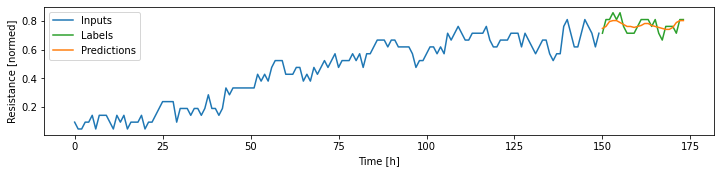

In [25]:
IPython.display.clear_output()

#multi_val_performance = model.evaluate(multi_window.val)
#multi_performance = model.evaluate(multi_window.test, verbose=0)
multi_window.plot(model)

In [25]:
test_df_test.shape()

TypeError: 'tuple' object is not callable

In [ ]:
pred = model.predict(test_df_test)